# SARS-CoV-2 Signature Scores on WTA Alveolar ROIs

In [1]:
import numpy as np
import pandas as pd
import pegasus as pg
import matplotlib.pyplot as plt

from typing import List, Tuple

### Nanostring WTA data: COVID high vs. COVID low

In [2]:
input_files = ['data/Broad-COVID_WTA_Q3Norm_TargetCountMatrix.txt', 
               'data/Broad-COVID_WTA_SegmentProperties.txt', 
               'data/annotation_file_wta.txt']
data = pg.read_input(input_files)
data.log_transform()
data._inplace_subset_obs(data.obs['Patient_ID'] != 'None')

2021-04-05 15:22:32,548 - pegasusio.readwrite - INFO - nanostring file '['data/Broad-COVID_WTA_Q3Norm_TargetCountMatrix.txt', 'data/Broad-COVID_WTA_SegmentProperties.txt', 'data/annotation_file_wta.txt']' is loaded.
2021-04-05 15:22:32,549 - pegasusio.readwrite - INFO - Function 'read_input' finished in 1.61s.


The signature scores are calculated using WTA cell type markers in _Extended Data Table 14_:

In [3]:
pg.calc_signature_score(data, 'utils/lung_spatial_markers.gmt')

2021-04-05 15:22:33,050 - pegasus.tools.signature_score - INFO - Loaded signatures from GMT file utils/lung_spatial_markers.gmt.
2021-04-05 15:22:33,052 - pegasus.tools.signature_score - INFO - Signature AT1: 10 out of 10 genes are used in signature score calculation.
2021-04-05 15:22:33,055 - pegasus.tools.signature_score - INFO - Signature AT2: 10 out of 10 genes are used in signature score calculation.
2021-04-05 15:22:33,059 - pegasus.tools.signature_score - INFO - Signature Ciliated cell: 10 out of 10 genes are used in signature score calculation.
2021-04-05 15:22:33,062 - pegasus.tools.signature_score - INFO - Signature Secretory cell: 10 out of 10 genes are used in signature score calculation.
2021-04-05 15:22:33,065 - pegasus.tools.signature_score - INFO - Signature B cell: 10 out of 10 genes are used in signature score calculation.
2021-04-05 15:22:33,069 - pegasus.tools.signature_score - INFO - Signature Plasma cell: 8 out of 10 genes are used in signature score calculation.


## Figure 4D & Extended Data Figure 8L

In [4]:
def studyVirus(donor = None, tissue = None, segment = None):
    idx = data.obs['Patient_ID'].map(lambda x: x[0] == 'S').values
    if donor is not None:
        idx &= (data.obs['Patient_ID'] == donor)
    if tissue is not None:
        tissue = tissue.split(';')
        idx &= np.isin(data.obs['Primary_Morph'], tissue)
    if segment is not None:
        idx &= (data.obs['segment'] == segment)
    ords= data.obs_names[idx][np.argsort(data.obs.loc[idx, 'Virus'].values)[::-1]]
    with open(f"WTA_SARS-CoV-2_{segment}.sig.csv", 'w') as fout:
        for key in ords:
            fout.write(f"{key},{data.obs.loc[key, 'Virus']}\n")

    up_mid = 1.30
    mid_low = 0.75
    
    x = np.array(list(range(1, len(ords) + 1)))
    y = data.obs.loc[ords, 'Virus'].values
    
    idx_h = y > up_mid
    idx_m = (y < up_mid) & (y > mid_low)
    idx_l = y < mid_low
    
    segment2source = {
        'PanCK': 'Figure_4/Source_Figure_4D.csv',
        'Syto13': 'ED_Figure_8/Source_ED_Figure_8L.csv',
    }
    
    plt.scatter(x[idx_h], y[idx_h], s=5, color = 'red', label = 'COVID high')
    plt.scatter(x[idx_m], y[idx_m], s=5, color = 'gray', label = 'COVID medium')
    plt.scatter(x[idx_l], y[idx_l], s=5, color = 'blue', label = 'COVID low')
    plt.legend(loc = "best")
#     plt.axhline(y=y, ls='--', linewidth=1, color = 'red')
    plt.xlabel("Rank")
    plt.ylabel("COVID-19 Signature Score")
    plt.gcf().dpi = 500
    
    z = np.array(['Low' for n in range(x.size)])
    z[idx_h] = 'High'
    z[idx_m] = 'Medium'
    df_seg = pd.DataFrame({'Rank': x, 'COVID-19 Signature Score': y, 'COVID-19 Level': z})
    df_seg.to_csv(segment2source[segment], index=False)

## Figure 4D

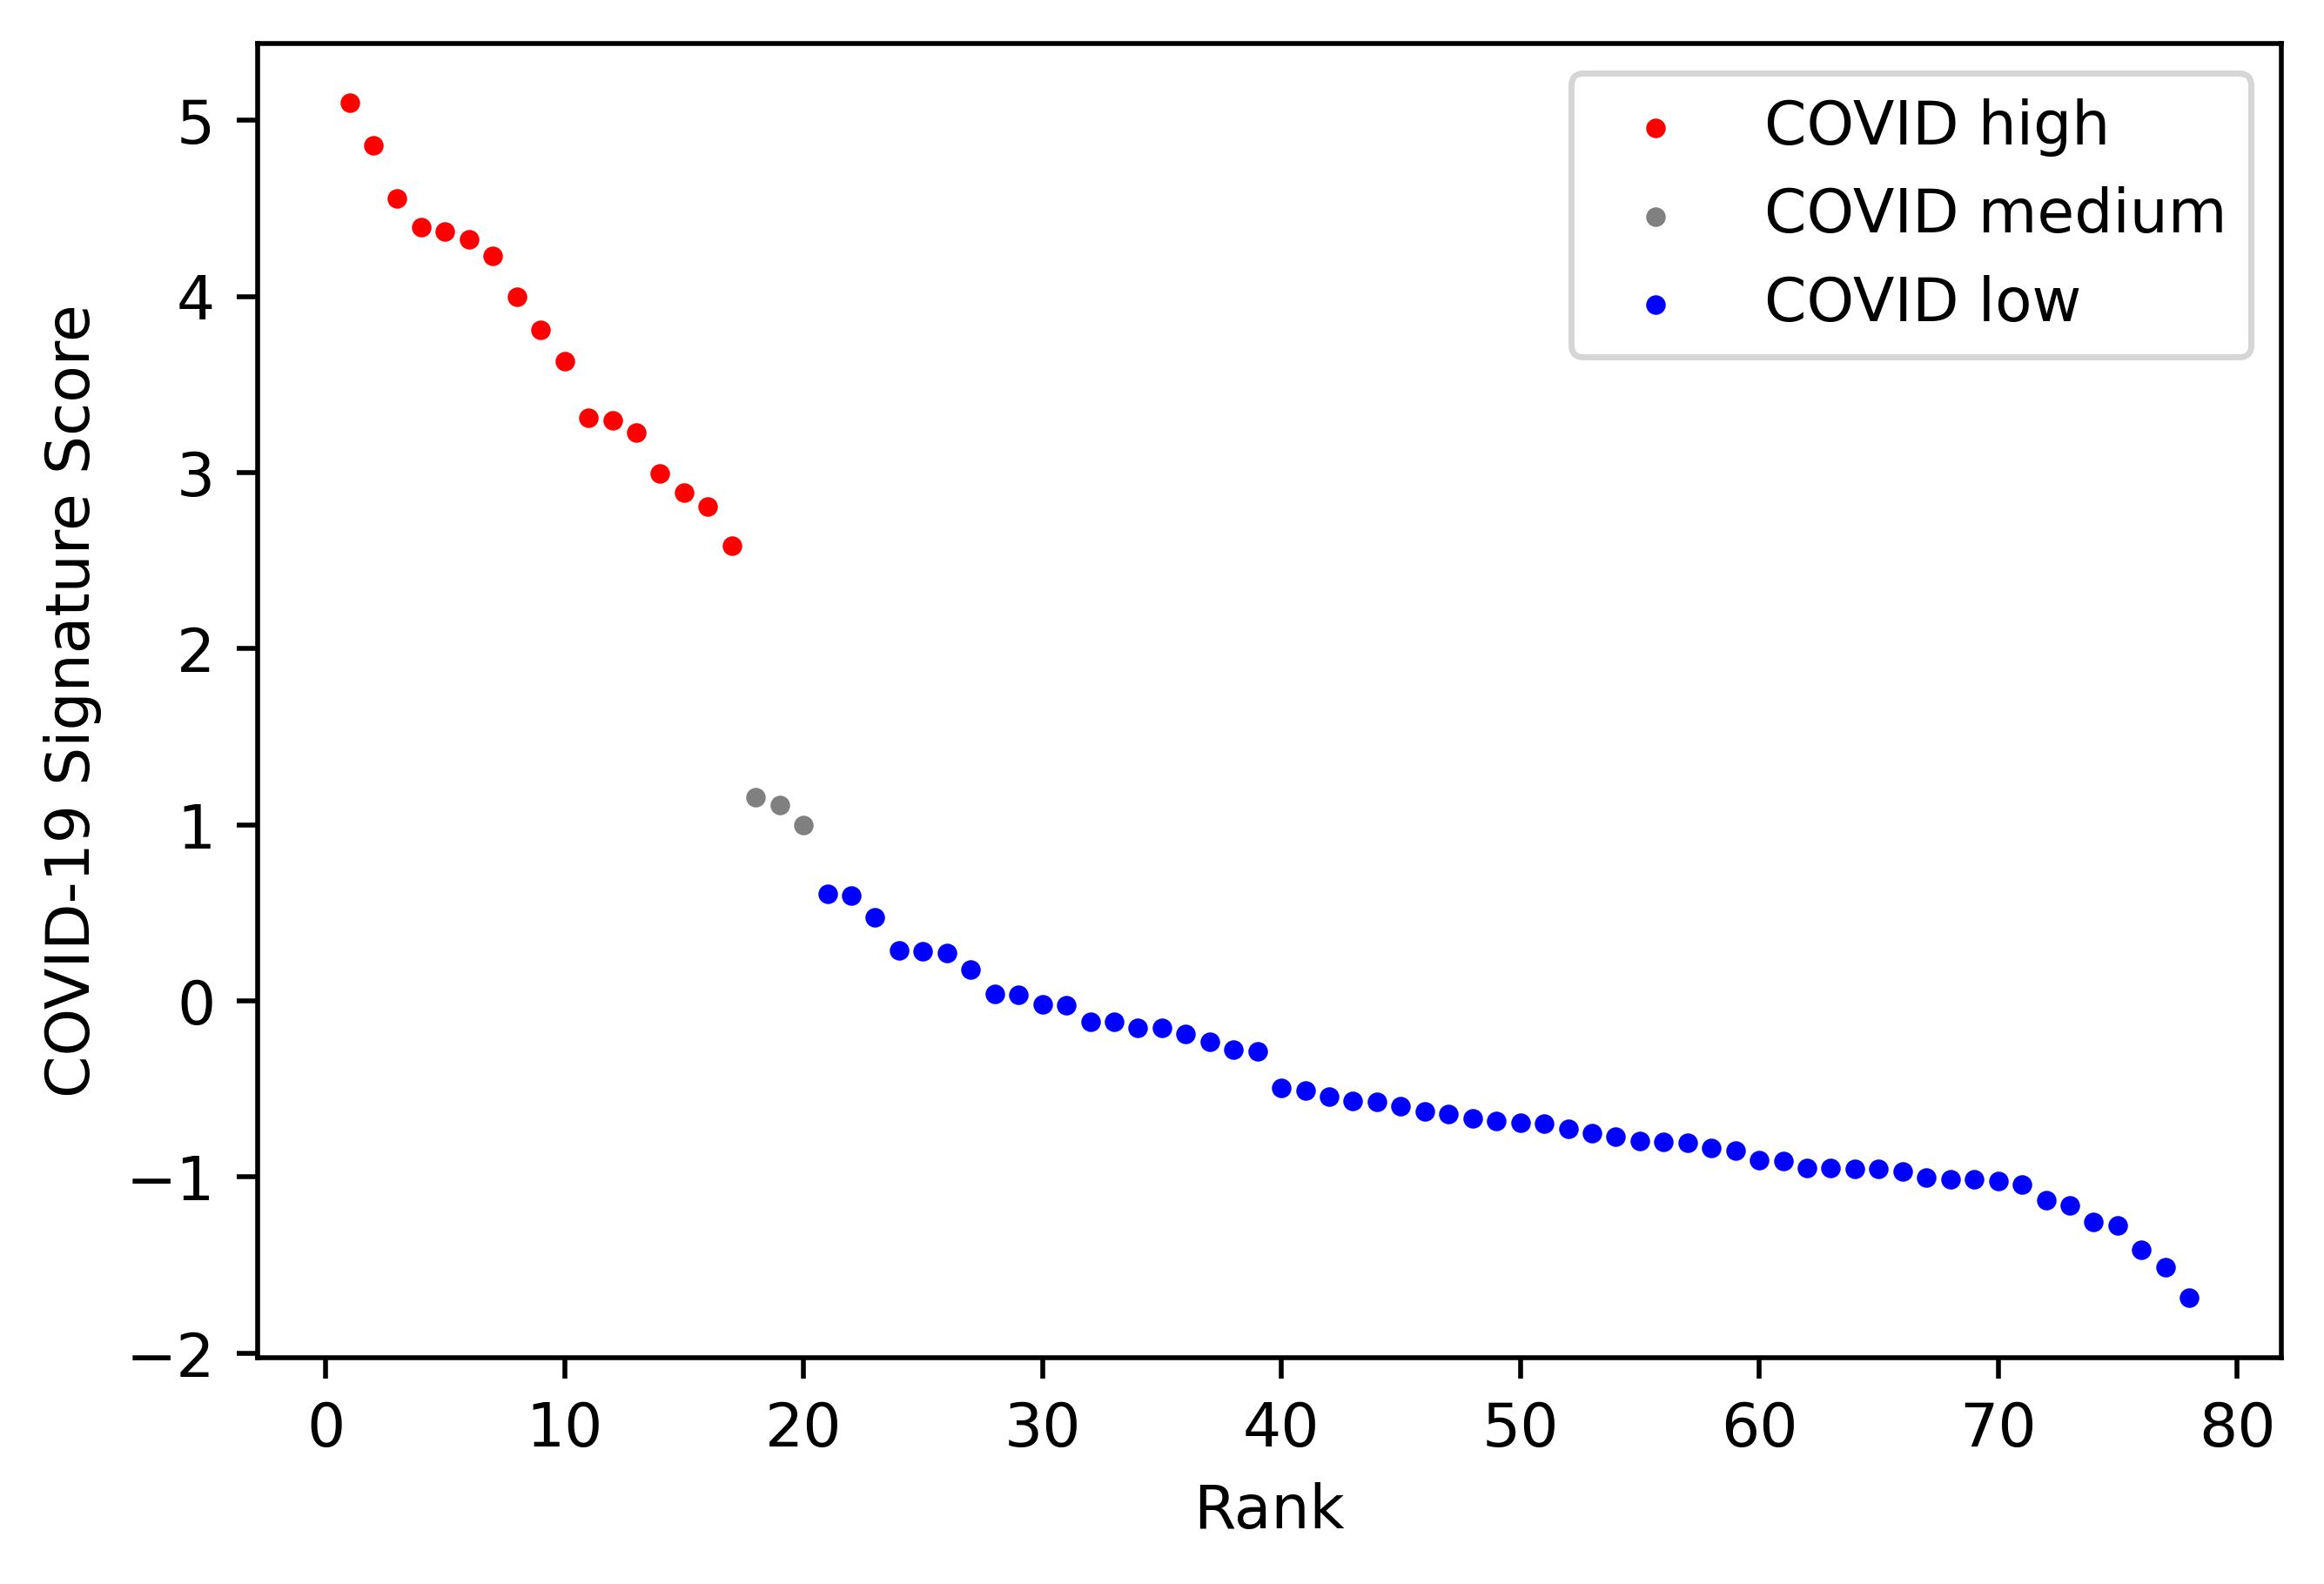

In [5]:
studyVirus(tissue = 'Alveolar', segment = 'PanCK')

## Extended Data Figure 8L

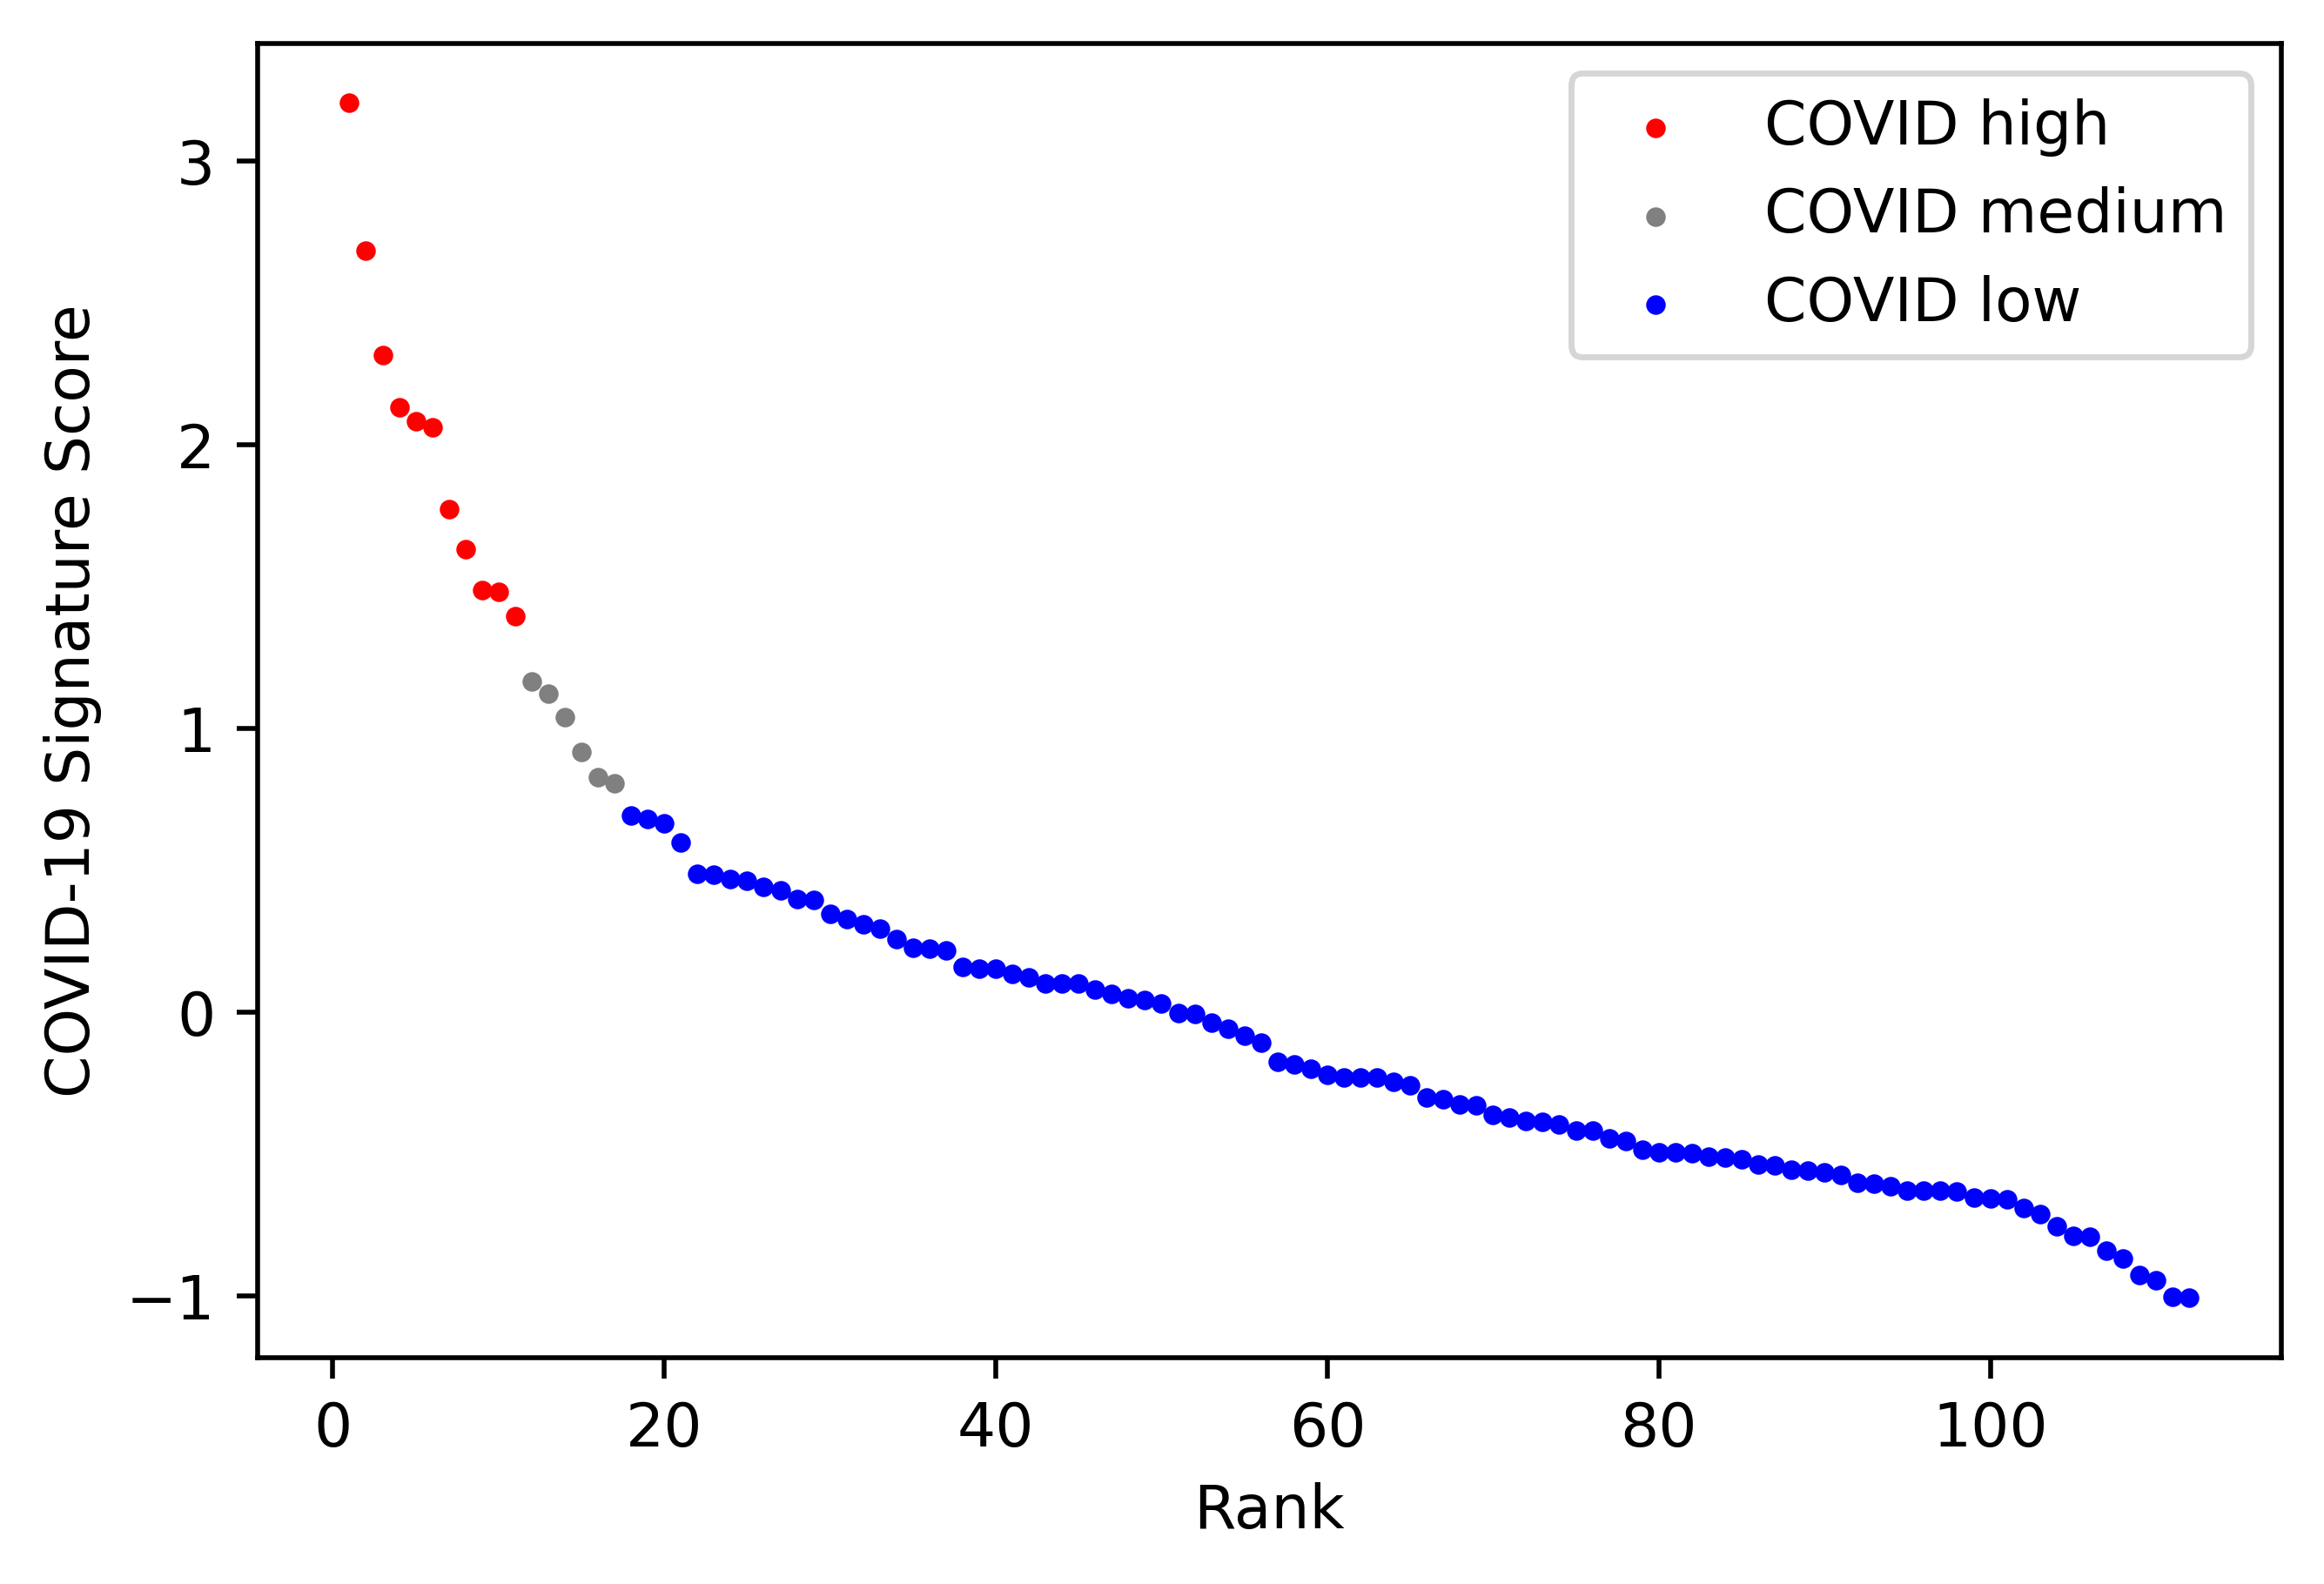

In [6]:
studyVirus(tissue = 'Alveolar', segment = 'Syto13')